# Map algebra

Map algebra is often used as an umbrella term for conducting various mathematical and logical operations, as well as spatial analysis operations, based on raster data. These techniques were first developed by Dana Tomlin in the 1970's ({cite}`Tomlin1990`) and they have since then been a fundamental part of raster data analysis in GIS. Map algebra provides a set of operators that can be applied to a single or multiple raster layers to produce a new raster layer. For instance, you can do basic mathematical calculations (multiply, sum, divide, etc.) between multiple raster layers that are central operations for map overlay analysis, or conduct mathematical operations on a single raster to compute values based on a given neighborhood. The latter can be used e.g. to detect hot spots based on the pixel values, in which high values are surrounded by other high values. Map algebra is widely used in terrain analysis, land suitability modeling, hydrological modeling, and environmental assessments. By integrating spatial data with mathematical functions, it enables powerful spatial decision-making.

The operations of map algebra can be divided into different categories:

- **Focal operations** compute values based on a specified neighborhood (e.g. 3x3 window) on a given raster layer.
- **Local operations** apply functions on a cell-by-cell basis between multiple raster layers.
- **Global operations** use all raster cells in computations to calculate e.g. statistical summaries.
- **Zonal operations** analyze values within defined zones, such as calculating average elevation within a watershed.
- **Incremental operations** apply iterative calculations or cumulative functions over space or time (e.g. cumulative cost surfaces).

There are various Python libraries that can be used for map algebra. Here, we are focusing on `xarray`, `xarray-spatial` and `rasterstats` libraries that provide numerous useful functionalities to conduct focal, local, global, zonal and incremental operations using raster data. In the following, we will apply map algebra to Digital Elevation Model (DEM) raster data obtained from Eastern Finland to gain knowledge of the topography in this area. In addition, we will learn how it is possible to conduct suitability analysis to find an optimal location to build a new summer house based on specific criteria, and how to conduct path finding on raster data to find least-cost route between two locations across the raster cost surface. 

## Focal operations

A focal function operates on a cell and its neighboring cells within a defined window (e.g., 3x3 or 5x5). The output value for each cell is derived by applying a mathematical or statistical operation to the values within that neighborhood. **Figure 7.xx** shows an example of a *focal sum* that is summing the input layer values to produce the pixel value in the output layer based on 3x3 window. For instance at the highlighted position (circled) on the right, the pixel will get a value 50 after summing the center pixel and the surrounding pixels in the input layer (left). In a similar manner, the 3x3 moving window is applied to all pixels in the images which creates the output raster seen on the right. Do you notice how the values at the edges of the output layer tend to be smaller? This happens because at the edges of the raster the 3x3 moving window moves "outside" of the raster area and thus has fewer input pixels that can be taken into account when doing the calculation. This kind of *{term}`edge effect`* is very typical when working with geographic data and you can deal with the issue by ensuring that the input data covers a bit of extra buffer (i.e. additional pixels) around the area of interest where you conduct the analysis. 

In addition to sum operation, you can apply any mathematical operator to calculate the pixel values, such as `mean`, `median`, `max`, `min`, `std`. Focal operations can be used also to conduct more complex calculations, such as doing edge detection or determining the slope of a terrain which we will learn next.


![_**Figure 7.XX.** Focal operation based on 3x3 window that considers the neighboring cells to all directions to define the cell value in the output raster._In this case, the output value is a sum of all input pixels](../img/focal-sum.png)
_**Figure 7.XX.** Focal operation based on 3x3 window that considers the neighboring cells to all directions to define the cell value in the output raster. In this case, the output value is a sum of all input pixels._

Now as we have learned the basic idea of focal operation, we can move forward to see how we can take advantage of different kind of focal operations to extract relevant information about the landscape (terrain) that can help us to find a suitable place to build a new summer house. Let's start by reading the Digital Elevation Model from a NetCDF file using `xarray`: 

In [1]:
import xarray as xr
import xrspatial
import matplotlib.pyplot as plt

fp = "data/Tuupovaara_DEM.nc"
data = xr.open_dataset(fp, decode_coords="all")
data

<xarray.Dataset> Size: 1MB
Dimensions:      (x: 400, y: 400)
Coordinates:
  * x            (x) float64 3kB 3.69e+06 3.69e+06 3.69e+06 ... 3.7e+06 3.7e+06
  * y            (y) float64 3kB 6.95e+06 6.95e+06 ... 6.94e+06 6.94e+06
    spatial_ref  int64 8B ...
Data variables:
    elevation    (y, x) float64 1MB ...
Attributes:
    AREA_OR_POINT:  Area

The dimensions of our data is 400x400 pixels and there is one data variable (`elevation`) that we can use to calculate various topography related indicators. Let's first plot our data with contour lines to get a sense of how the landscape looks like in Eastern Finland close to Tuupovaara:

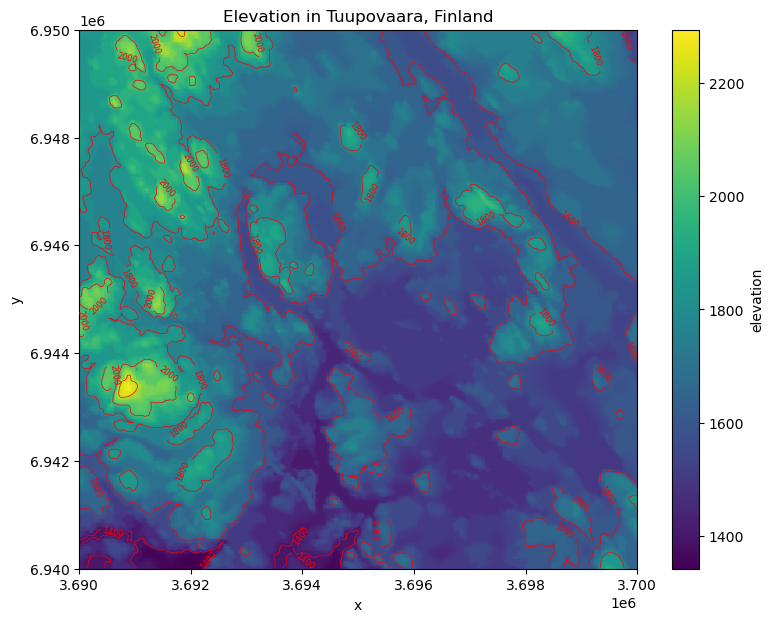

In [3]:
# Plot the elevation values and contours
fig, ax = plt.subplots(figsize=(9, 7))
data["elevation"].plot(ax=ax)
cs = data["elevation"].plot.contour(ax=ax, colors="red", linewidths=0.5)

# Label contours
ax.clabel(cs, cs.levels, inline=True, fontsize=6)
plt.title("Elevation in Tuupovaara, Finland");

_**Figure 7.X.** Elevation surface with contour lines._

### Slope

One of the most useful ways to characterize and get a sense of a given landscape or terrain is to calculate *{term}`slope`*. Slope is a measure of the steepness or incline of the terrain which represents the rate of change in elevation over distance and is typically expressed in degrees or percent. Calculating slope can be done easily using the `xarray-spatial` library's `.slope()` function that takes the `elevation` values as input:

In [7]:
# Calculate slope
data["slope"] = xrspatial.slope(data["elevation"])
data["slope"].values

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,  5.063198 ,  5.2520905, ..., 23.836535 , 31.893763 ,
               nan],
       [       nan,  4.9166656,  5.267519 , ..., 23.46884  , 27.478767 ,
               nan],
       ...,
       [       nan, 18.101492 , 17.874008 , ...,  0.4051356,  0.4051356,
               nan],
       [       nan, 18.568825 , 18.101492 , ...,  0.       ,  0.5729387,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)

As output, we have an array where the slope for given pixel is represented in degrees. Slope is a focal operation that is calculated based on a moving window which is the reason that there are some `None` values as well at the edges of the array (i.e. the edge effect is present here). Let's finally visualize the slope to see how the steepness of the terrain varies in our study region:

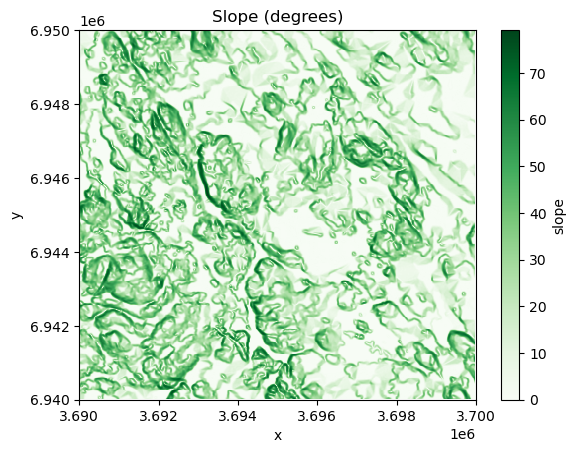

In [10]:
data["slope"].plot(cmap="Greens")
plt.title("Slope (degrees)");

_**Figure 7.X.** Slope in degrees calculated from the elevation data._

As we can see the western areas of the terrain include steep slopes highlighted with dark green color, while the central and eastern areas are more flat which are indicated with lighter tones. 

### Aspect

*{term}`Aspect`* shows the direction that a slope faces. It is measured in degrees from 0° (North) to 360°, and it helps to determine e.g. sunlight exposure, vegetation patterns, and microclimate conditions. Aspect can only be determined for areas that have some level of slope, i.e. flat areas that do not have any degree of change in elevation cannot have aspect either. To calculate aspect, we can use the `.aspect()` function of `xarray-spatial` that takes the elevation data as input:

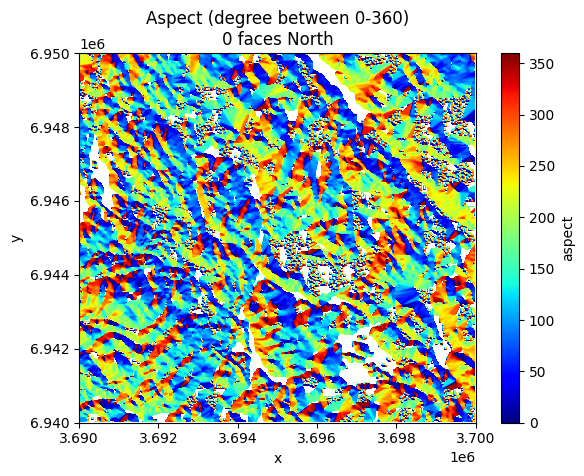

In [10]:
# Calculate aspect
data["aspect"] = xrspatial.aspect(data["elevation"])

# Filter values that are below 0 (areas without aspect defined)
data["aspect"] = data["aspect"].where(data["aspect"] >= 0)
data["aspect"].plot(cmap="jet")
plt.title("Aspect (degree between 0-360)\n0 faces North");

_**Figure 7.X.** Aspect surface shows the direction of the slope in degrees._

In the code above, we filtered out values that were below 0 as those indicate flat areas in the terrain (having value -1). The rather wild and colorful map that was produced based on the aspect values shows the direction of the slope for every pixel in the raster where the dark blue and red tones face North. To be more specific, the values can be decoded into different directions approximately as follows (following clockwise direction starting from the North):

- Values from 0 to 22.5 = North
- Values from 22.5 to 67.5 = Northeast
- Values from 67.5 to 112.5 = East
- Values from 112.5 to 157.5 = Southeast
- Values from 157.5 to 202.5 = South
- Values from 202.5 to 247.5 = West
- Values from 247.5 to 292.5 = Northwest
- Values from 337.5 to 360 = North



### Curvature

*{term}`Curvature`* describes how fast the slope is increasing or decreasing as we move along a surface. A positive curvature means that the surface is curving up (upwardly convex) at a given cell while negative curvature means that the surface is curving down (downwardly convex). A curvature of 0 means that the surface is straight (constant) in whatever angle it is sloped towards. Similarly as with the slope and aspect, we can calculate the curvature based on the elevation values using the `.curvature()` function:

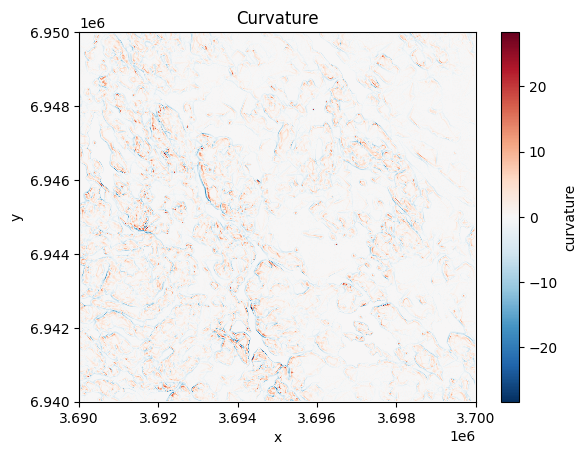

In [473]:
data["curvature"] = xrspatial.curvature(data["elevation"])
data["curvature"].plot()
plt.title("Curvature");

_**Figure 7.X.** Curvature describes the rate of change in the slope._

The map reveals that vast majority of the surface in our study area is straight having value of 0. However, few places can be spotted at the central and western parts of the region that show surfaces curwing upwards (red color) and downwards (blue color). These places tend to be located close to the areas with highest elevation values in this specific region. 


### Hot and cold spots

Hot and cold spots identify statistically significant hot spots and cold spots in an input raster. A statistically significant hot spot means that a given pixel has a high value and is surrounded by other high values. Thus, it is a similar measure to local spatial autocorrelation (LISA) although hot/cold spot analysis focuses on identifying only high-high and low-low areas, where as LISA also identify outliers (high values surrounded by low values). To identify hot and cold spots, we can use the `.hotspots()` function of the `xarray-spatial` that identifies hot and cold spots with varying degrees of confidence (90 %, 95 % and 99 %). To identify the hot spots, we also need to define the neighborhood (i.e. similar to moving window), that is used to compare values between the given pixel and its surrounding. We can do this by defining a `kernel` that can take different shapes, such as circle, annulus (ring-shaped) or a custom kernel. Here, we use a circle kernel with a size of five pixels (radius) and initialize it by using the `.convolution.circle_kernel()` function: 

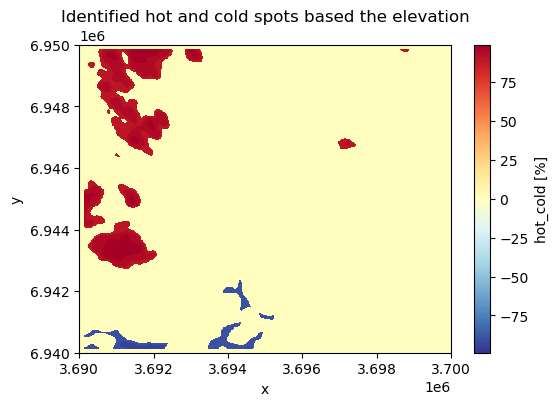

In [15]:
# Kernel size
k = 5

# Generate a kernel 
# The first two parameters with value 1 define the cell size 
# of output kernel in x and y direction
kernel = xrspatial.convolution.circle_kernel(1, 1, k)


data["hot_cold"] = xrspatial.focal.hotspots(data["elevation"], kernel)
data["hot_cold"].plot(cmap="RdYlBu_r", figsize=(6, 4))
plt.title("Identified hot and cold spots based on the elevation");

_**Figure 7.X.** Hot spots are clusters with high values surrounded by other high values._

The output map reveals that the statistically significant hot spots are located dominantly on the West and Northwest areas of the study region having areas with high elevation values while statistically significant cold spot areas are located on the Southwest. 

### Hillshade

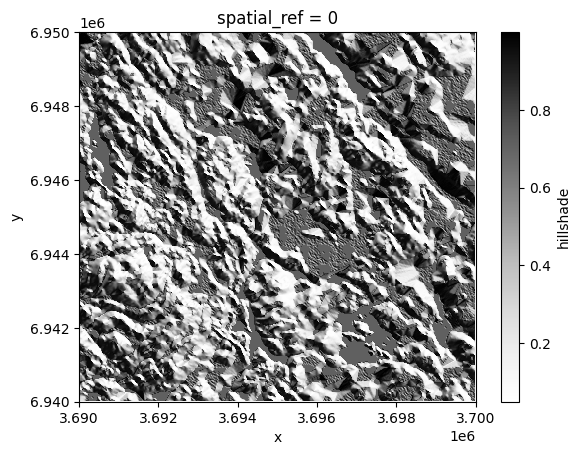

In [367]:
data["hillshade"] = xrspatial.hillshade(data["elevation"])
data["hillshade"].plot(cmap="Greys")

_**Figure 7.X.** Hillshade is a shaded relief based on the surface raster considering the illumination source angle and shadows._

In [48]:
# Calculate relative height
data["relative_height"] = data["elevation"] - data["elevation"].min().item()

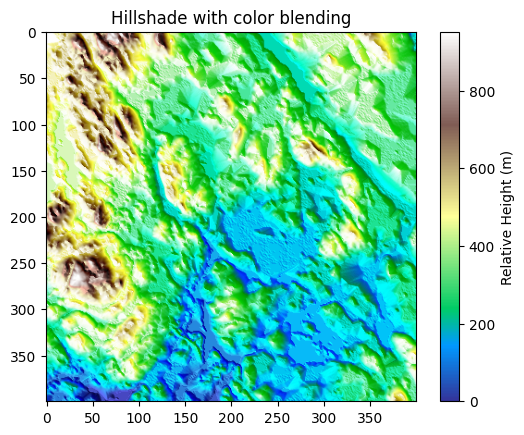

In [53]:
from matplotlib.colors import LightSource, Normalize
import matplotlib.colorbar as cbar
import matplotlib.cm as cm
import numpy as np

fig, ax = plt.subplots()

# Specify the colormap to use
colormap = plt.cm.terrain

# Specify the light source
ls = LightSource(azdeg=225, altdeg=25)

# Convert DataArray into numpy array
array = data["relative_height"].to_numpy()

# Normalize elevation for color mapping
norm = Normalize(vmin=np.min(array), vmax=np.max(array))

# Create hillshade based on elevation
hillshade = ls.shade(array, cmap=colormap, vert_exag=1, blend_mode="overlay")
ax.imshow(hillshade)
ax.set_title("Hillshade with color blending")

# Create a ScalarMappable for colorbar
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Needed for colorbar creation

# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", label="Relative Height (m)")

_**Figure 7.X.** Hillshade with color blending can give a more realistic appearance of the landscape_

### Smoothing and focal statistics

In [182]:
# Kernel size
k = 15

# Generate a kernel (basically produces a boolean matrix full with numbers 1 and 0)
kernel = xrspatial.convolution.circle_kernel(1, 1, k)

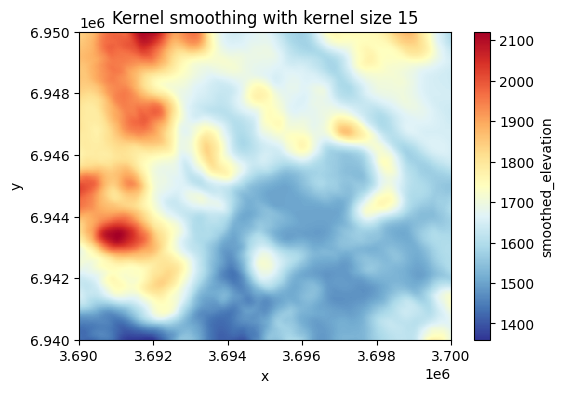

In [486]:
# Smoothen the surface
data["smoothed_elevation"] = xrspatial.focal.focal_stats(
    data["elevation"], kernel, stats_funcs=["mean"]
)

data["smoothed_elevation"].plot(cmap="RdYlBu_r", figsize=(6, 4))
plt.title("Kernel smoothing with kernel size 15");

_**Figure 7.X.** Smoothed surface based on the average elevation of 15 neighboring cells at each pixel._

## Local operations

A local function operates .. Chapter 7.6 includes many more examples of using local operations related to working with multiband satellite data and geospatial timeseries data spanning multiple years.

### Reclassification

The goal in the following section is to calculate and use different surface features to find a suitable place for building a new summer house. To do this, we will use information for example about elevation, slope and aspect of the terrain. so think of a scenario where all of these can be utilized. The criteria for finding a suitable place for a summer cottage will be based on following preferences:

- The higher the elevation, the better
- Some slope is good but not too steep
- The ridge should be pointing South (who wouldn't like more sun on their patio..)

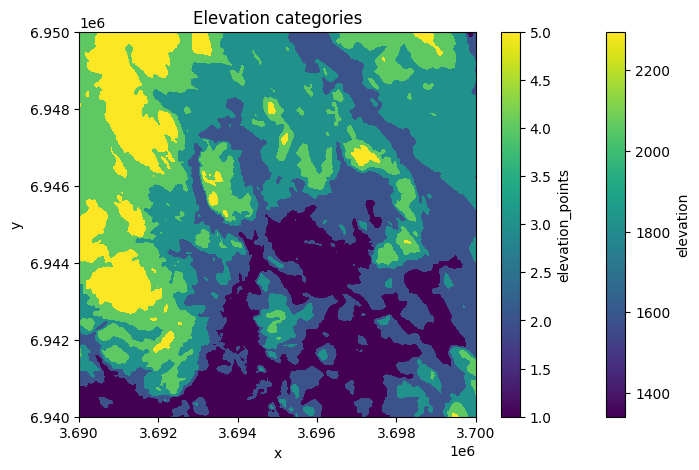

In [488]:
# Take 20 % sample to reduce the time it takes to classify
percentage = 0.2

# The sample size
n = int(round(int(data["elevation"].count()) * percentage, 0))

# Reclassify elevation into 5 classes and add number 1 to the result to make the scale from 1-5
data["elevation_points"] = (
    xrspatial.classify.natural_breaks(data["elevation"], k=5, num_sample=n) + 1
)

# Plot the result
fig, ax = plt.subplots(figsize=(8, 5))
data["elevation"].plot(ax=ax)
data["elevation_points"].plot(ax=ax)
plt.title("Elevation categories");

_**Figure 7.X.** Elevation categories (k=5) based on natural breaks classification scheme._

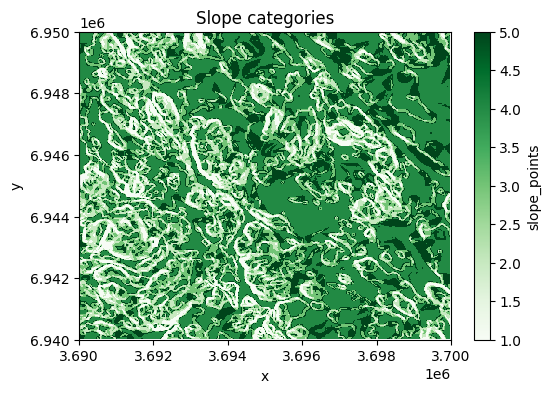

In [487]:
bins = [1, 2, 3, 4, 5]
new_values = [4, 5, 3, 2, 1]

data["slope_nb"] = (
    xrspatial.classify.natural_breaks(data["slope"], k=5, num_sample=n) + 1
)
data["slope_points"] = xrspatial.classify.reclassify(
    data["slope_nb"], bins=bins, new_values=new_values
)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
data["slope_points"].plot(ax=ax, cmap="Greens")
plt.title("Slope categories");

_**Figure 7.X.** Slope categories (k=5) based on natural breaks classification scheme._

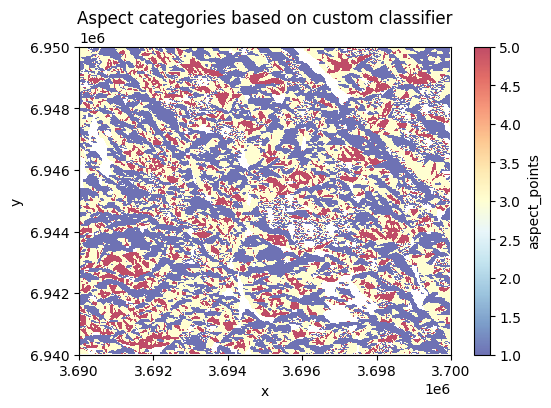

In [489]:
bins = [90, 150, 210, 270, 360]
new_values = [1, 3, 5, 3, 1]

# Classify
data["aspect_points"] = xrspatial.classify.reclassify(
    data["aspect"], bins=bins, new_values=new_values
)

# Make a plot
fig, ax = plt.subplots(figsize=(6, 4))
data["aspect_points"].plot(ax=ax, cmap="RdYlBu_r", alpha=0.7)
plt.title("Aspect categories based on custom classifier");

_**Figure 7.X.** Aspect categories based on a custom a custom classification scheme._

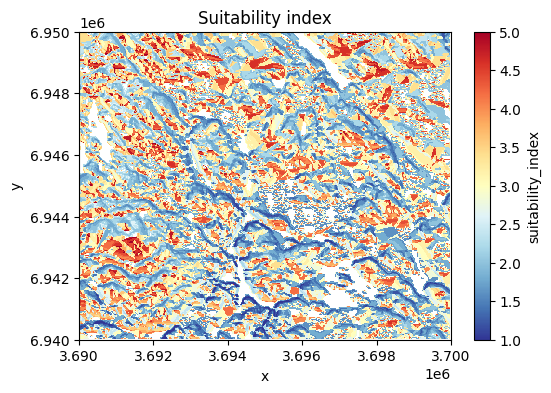

In [490]:
# Calculate the suitability index by weighting the "points" given for different layers
data["suitability_index"] = (
    data["elevation_points"] * 0.2
    + data["aspect_points"] * 0.6
    + data["slope_points"] * 0.2
)

# Plot the suitability index
data["suitability_index"].plot(cmap="RdYlBu_r", figsize=(6, 4))
plt.title("Suitability index");

_**Figure 7.X.** Suitability index calculated based on elevation, aspect and slope._

## Global operations

In map algebra, global functions are operations where the output value of each cell depends on the entire dataset or a large spatial extent, not just local neighbors. These functions are used to analyze patterns, relationships, and spatial influences across the whole raster. They are essential for modeling cumulative effects, spatial dependencies, and large-scale patterns in fields like hydrology, transportation, and environmental science.

### Statistical summaries

In [167]:
data["elevation"].min().item()

1342.0

In [168]:
data["elevation"].max().item()

2294.0

In [169]:
data["elevation"].mean().item()

1663.44648125

In [170]:
data["elevation"].median().item()

1649.0

In [171]:
data["elevation"].std().item()

147.3785525805685

### Viewshed

In [185]:
from shapely import box, Point
import geopandas as gpd

# Extract the center coordinates of the raster
bbox = box(*data.rio.bounds())
xcoord = bbox.centroid.x
ycoord = bbox.centroid.y

# Create a GeoDataFrame of the centroid
observer_location = gpd.GeoDataFrame(geometry=[Point(xcoord, ycoord)], crs=data.rio.crs)

In [477]:
# Elevation at a given point
elevation = data["elevation"].interp(x=xcoord, y=ycoord).item()
print("Elevation in the location of observer:", elevation, "meters.")

Elevation in the location of observer: 1509.25 meters.


Let's imagine that there is a bird watching tower that rises 10 meters above the ground. In the following, we assume that a person is viewing the landscape on top of this tower to improve the visibility of the landscape. To calculate viewshed from this observation point, we can use `.viewshed()` function from the `xrspatial` library as follows:

In [482]:
# Observer elevation
observer_elevation = 10

# Calculate viewshed
data["viewshed"] = xrspatial.viewshed(
    data["elevation"], x=xcoord, y=ycoord, observer_elev=observer_elevation
)

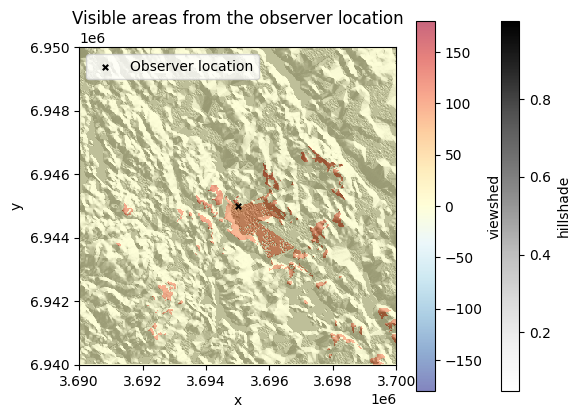

In [483]:
fig, ax = plt.subplots()

# Plot hillshade that was calculated earlier
data["hillshade"].plot(ax=ax, cmap="Greys")

# Plot viewshed
data["viewshed"].plot(ax=ax, cmap="RdYlBu_r", alpha=0.6)

# Observer location
observer_location.plot(
    ax=ax, color="black", marker="x", markersize=15, label="Observer location"
)

# Add legend and title
ax.legend(loc="upper left")
ax.set_title("Visible areas from the observer location");

_**Figure 7.X.** Visible areas from the observer location based on the viewshed analysis._

## Zonal operations

To be added. 

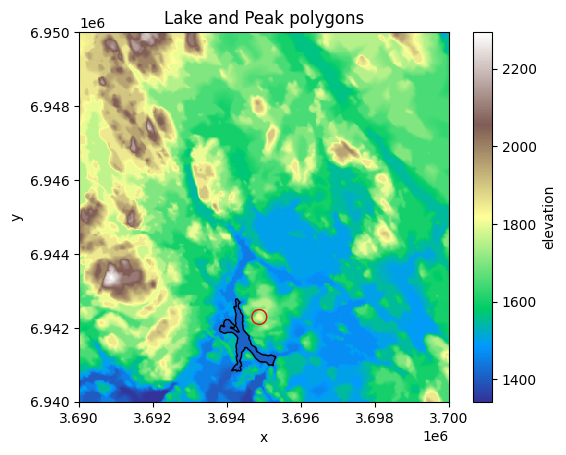

In [438]:
import osmnx as ox
from shapely import box

# Fetch lake "Riuttanen" from OSM
lake = ox.geocode_to_gdf("Riuttanen, Joensuu")
lake = gdf1.to_crs(crs=data.rio.crs)

# Fetch peak Riuttavaara based on OSM Node ID
peak = ox.geocode_to_gdf("N11034739930", by_osmid=True)
peak = peak.to_crs(crs=data.rio.crs)

# Create a buffer around the peak
peak["geometry"] = peak.buffer(200)

# Plot
fig, ax = plt.subplots()

data["elevation"].plot(ax=ax, cmap="terrain")
lake.plot(ax=ax, facecolor="None")
peak.plot(ax=ax, edgecolor="red", facecolor="None")
ax.set_title("Lake and Peak polygons");

_**Figure 7.X.** Two zones that are used for comparison and calculating zonal statistics._

In [469]:
# Merge zones into a single GeoDataFrame
zones = pd.concat([peak, lake]).reset_index(drop=True)

In [470]:
import rasterstats
import pandas as pd

elevation_array = data["elevation"].to_numpy()
affine = data.rio.transform()

# Run the zonal statistics
stats = rasterstats.zonal_stats(
    zones,
    elevation_array,
    affine=affine,
    stats=["mean", "min", "max", "std"],  # Statistics to calculate
    nodata=data["elevation"].rio.nodata,  # Handle nodata values
)

stats

[{'min': 1650.0,
  'max': 1800.0,
  'mean': 1727.7313432835822,
  'std': 44.88168484486737},
 {'min': 1408.0,
  'max': 1471.0,
  'mean': 1409.546827794562,
  'std': 3.8168113458094}]

In [471]:
stats = pd.DataFrame(stats)
stats

min     max         mean        std
0  1650.0  1800.0  1727.731343  44.881685
1  1408.0  1471.0  1409.546828   3.816811

In [472]:
zones = zones.join(stats)
zones

geometry  bbox_west  bbox_south  \
0  POLYGON ((3695077.073 6942292.381, 3695076.11 ...  30.783790   62.534025   
1  POLYGON ((3693801.983 6941952.076, 3693802.445...  30.762616   62.521290   

   bbox_east  bbox_north   place_id  osm_type       osm_id        lat  \
0  30.783890   62.534125  155389184      node  11034739930  62.534075   
1  30.791158   62.538771  155368181  relation      8774094  62.530008   

         lon  ...   type place_rank  importance  addresstype         name  \
0  30.783840  ...   peak         18    0.160063         peak  Riuttavaara   
1  30.774021  ...  water         22    0.106730        water    Riuttanen   

                                        display_name     min     max  \
0  Riuttavaara, Joensuu, Joensuu sub-region, Nort...  1650.0  1800.0   
1  Riuttanen, Joensuu, Joensuu sub-region, North ...  1408.0  1471.0   

          mean        std  
0  1727.731343  44.881685  
1  1409.546828   3.816811  

[2 rows x 21 columns]

In [468]:
# What is the maximum difference in elevation between peak and lake?
difference = zones.at[0, "mean"] - zones.at[1, "mean"]
print(f"Elevation difference between the peak and lake: {difference:.0f} m.")

Elevation difference between the peak and lake: 318 m.


## Incremental operations

Incremental operations .. 

### Least-cost path calculation based on raster surface

In [238]:
origin = gpd.GeoDataFrame(geometry=[Point(3691000, 6942000)], crs=data.rio.crs)
destination = gpd.GeoDataFrame(geometry=[Point(3698500, 6948000)], crs=data.rio.crs)

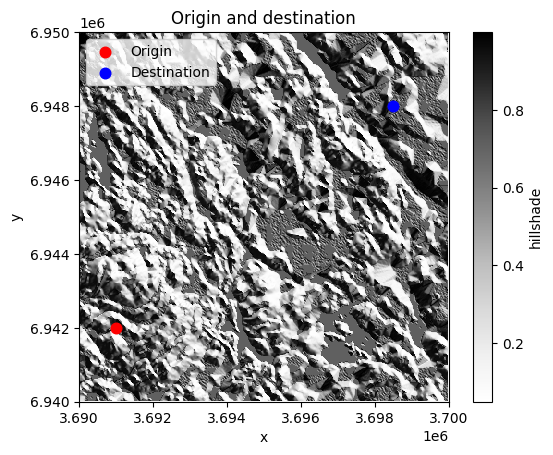

In [244]:
fig, ax = plt.subplots()

data["hillshade"].plot(ax=ax, cmap="Greys")
origin.plot(ax=ax, color="red", markersize=58, label="Origin")
destination.plot(ax=ax, color="blue", markersize=58, label="Destination")
ax.legend(loc="upper left")
plt.title("Origin and destination");

_**Figure 7.X.** Origin and destination points that are used to find the least-cost path across the surface._

In [319]:
barriers = list(range(1400, 1580))
barriers += list(range(2000, 2200))

origin_latlon = (origin.geometry.y.item(), origin.geometry.x.item())
destination_latlon = (destination.geometry.y.item(), destination.geometry.x.item())

In [320]:
least_cost_path = xrspatial.a_star_search(
    data["elevation"], origin_latlon, destination_latlon, barriers
)

In [321]:
route = xr.where(~np.isnan(least_cost_path), 1, least_cost_path)

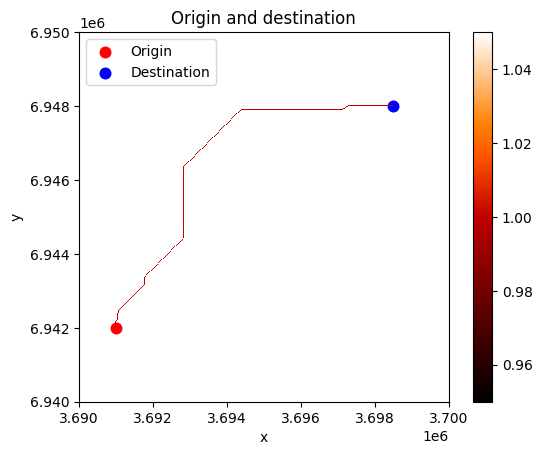

In [360]:
fig, ax = plt.subplots()

origin.plot(ax=ax, color="red", markersize=58, label="Origin")
destination.plot(ax=ax, color="blue", markersize=58, label="Destination")
route.plot(ax=ax, cmap="gist_heat")
ax.legend(loc="upper left")
plt.title("Origin and destination");

_**Figure 7.X.** The calculated least-cost path from origin to destination based on A\* algorithm._

In [356]:
from shapely import LineString

# Convert (row, col) path to geographic coordinates
transform = data.rio.transform()

# Extract (row, col) indices where path is not NaN
path_indices = np.argwhere(~np.isnan(least_cost_path.values))

coords = [transform * (int(col), int(row)) for row, col in path_indices]

# Create a LineString from the path
line = LineString(coords)

# Convert to a GeoDataFrame
shortest_path = gpd.GeoDataFrame({"geometry": [line]}, crs=data.rio.crs)

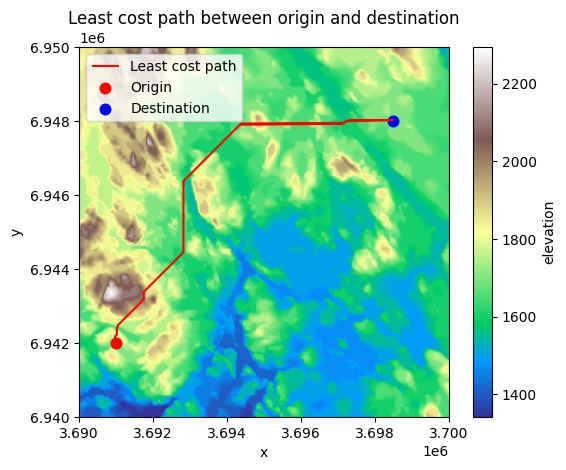

In [369]:
fig, ax = plt.subplots()

data["elevation"].plot(ax=ax, cmap="terrain")
shortest_path.plot(ax=ax, color="red", label="Least cost path")
origin.plot(ax=ax, color="red", markersize=58, label="Origin")
destination.plot(ax=ax, color="blue", markersize=58, label="Destination")
ax.legend(loc="upper left")
plt.title("Least cost path between origin and destination");

_**Figure 7.X.** Vectorized least-cost path (LineString) across the terrain._

### Flow accumulation

Flow accumulation for example related to watershed analysis is another example of incremental operation. **ADD MORE INFO**. Chapter 12 will cover examples how incremental operations are used to calculate watersheds based in digital elevation model in New Zealand.